In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math

The base requirement for running this pipeline is that a dataset is comprised of the following columns:
- `assay_id`
- `treatment_id`
- `sample_id`
- `well_row`
- `well_column`
- `rlu_value`
- `timepoint`

The first step is to compute the relevant values which can then be used to filter and asses the data for plotting. The necessary values are:

- `inter_timepoint_fold_change` (the fold change between 2 consecutive timepoints)
- `total_fold_change` (the fold change between t0 and every subsequent timepoint)


In [3]:
df = pd.read_csv("formatted_data.csv")

def group_dx(group: pd.DataFrame) -> pd.DataFrame:
    group.sort_values("timepoint", inplace=True)
    first_timepoint = group.loc[group["timepoint"] == group["timepoint"].min()]
    first_rlu = first_timepoint["rlu_value"].values[0]
    group["total_fold_change"] = [x / first_rlu for x in group["rlu_value"]]
    group["inter_timepoint_fold_change"] = [1 + x for x in group["rlu_value"].pct_change().fillna(0)]
    return group

df = df.groupby(["sample_id"], as_index=False, group_keys=False).apply(group_dx)
df.head()

,Unnamed: 0,assay_id,treatment_id,sample_id,well_row,well_column,rlu_value,timepoint,total_fold_change,inter_timepoint_fold_change
0,0,plate018,DC3000_MQ,plate018_A_1,A,1,13891.0,2.5,1.000000,1.000000
1,1,plate018,DC3000_MQ,plate018_A_1,A,1,10231.0,5.0,0.736520,0.736520
2,2,plate018,DC3000_MQ,plate018_A_1,A,1,9675.0,7.5,0.696494,0.945655
3,3,plate018,DC3000_MQ,plate018_A_1,A,1,9498.0,10.0,0.683752,0.981705
4,4,plate018,DC3000_MQ,plate018_A_1,A,1,9264.0,12.5,0.666907,0.975363


With these values it is now possible to detect outliers per assay. In the next block you can identify which `sample_id`s should be excluded from the data. Specify which assay to view by modifying the `assay_id`.

In [4]:
ASSAY_ID = "plate018"
EXCLUDE = [
    "plate018_A_7",
]
filtered_df = df.loc[df["assay_id"] == ASSAY_ID]
filtered_df = filtered_df[~filtered_df["sample_id"].isin(EXCLUDE)]

# Toggle comments for below lines to run visualization of the plate grid

# grid = sns.FacetGrid(data=filtered_df, col="well_column", row="well_row")
# grid.map_dataframe(sns.lineplot, x="timepoint", y="inter_timepoint_fold_change")

clean_df = df[~df["sample_id"].isin(EXCLUDE)]
clean_df.head()


,Unnamed: 0,assay_id,treatment_id,sample_id,well_row,well_column,rlu_value,timepoint,total_fold_change,inter_timepoint_fold_change
0,0,plate018,DC3000_MQ,plate018_A_1,A,1,13891.0,2.5,1.000000,1.000000
1,1,plate018,DC3000_MQ,plate018_A_1,A,1,10231.0,5.0,0.736520,0.736520
2,2,plate018,DC3000_MQ,plate018_A_1,A,1,9675.0,7.5,0.696494,0.945655
3,3,plate018,DC3000_MQ,plate018_A_1,A,1,9498.0,10.0,0.683752,0.981705
4,4,plate018,DC3000_MQ,plate018_A_1,A,1,9264.0,12.5,0.666907,0.975363


With the outliers and faulty samples removed, it now makes sense to normalise for the control sample. In the following code block the mean values of the control samples is deducted from the treatments. 

In [5]:
CONTROL_ID = "D36E_MQ"

ctrl_df = clean_df.loc[df["treatment_id"] == CONTROL_ID]
ctrl_group = ctrl_df.groupby(["assay_id", "timepoint"], as_index=False, group_keys=False)\
    .agg(
        inter_timepoint_fold_change_ctrl=("inter_timepoint_fold_change", "mean"),
    )
normalised_df = clean_df.merge(
    ctrl_group[[
        "assay_id",
        "timepoint",
        "inter_timepoint_fold_change_ctrl",
    ]],
    on=["assay_id", "timepoint"]
)
normalised_df["inter_timepoint_fold_change"] = normalised_df["inter_timepoint_fold_change"] / normalised_df["inter_timepoint_fold_change_ctrl"]
normalised_df["inter_timepoint_fold_change"] = [math.log2(x) for x in normalised_df["inter_timepoint_fold_change"]]
normalised_df.head(100)

,Unnamed: 0,assay_id,treatment_id,sample_id,well_row,well_column,rlu_value,timepoint,total_fold_change,inter_timepoint_fold_change,inter_timepoint_fold_change_ctrl,total_fold_change_ctrl,rlu_value_ctrl,relative_to_ctrl
0,0,plate018,DC3000_MQ,plate018_A_1,A,1,13891.0,2.5,1.000000,1.000000,1.000000,1.000000,11670.875000,0.000000
1,40,plate018,D36E_MQ,plate018_A_2,A,2,10043.0,2.5,1.000000,1.000000,1.000000,1.000000,11670.875000,0.000000
2,80,plate018,D36E+HopA1_Bacterial PAMPs,plate018_A_3,A,3,924.0,2.5,1.000000,1.000000,1.000000,1.000000,11670.875000,0.000000
3,120,plate018,D36E+HopB1_Bacterial PAMPs,plate018_A_4,A,4,1156.0,2.5,1.000000,1.000000,1.000000,1.000000,11670.875000,0.000000
4,160,plate018,DC3000_Bacterial PAMPs,plate018_A_5,A,5,536.0,2.5,1.000000,1.000000,1.000000,1.000000,11670.875000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,plate018,DC3000_MQ,plate018_A_1,A,1,10231.0,5.0,0.736520,0.736520,0.843303,0.843303,10958.142857,-0.195327
96,41,plate018,D36E_MQ,plate018_A_2,A,2,8184.0,5.0,0.814896,0.814896,0.843303,0.843303,10958.142857,-0.049436
97,81,plate018,D36E+HopA1_Bacterial PAMPs,plate018_A_3,A,3,258.0,5.0,0.279221,0.279221,0.843303,0.843303,10958.142857,-1.594646
98,121,plate018,D36E+HopB1_Bacterial PAMPs,plate018_A_4,A,4,410.0,5.0,0.354671,0.354671,0.843303,0.843303,10958.142857,-1.249569


As an intermediary result you can inspect the mean values per assay in a line plot. In the following code block you can choose which value to plot and which assay to inspect. The available values are:
- `inter_timepoint_fold_change`
- `total_fold_change`

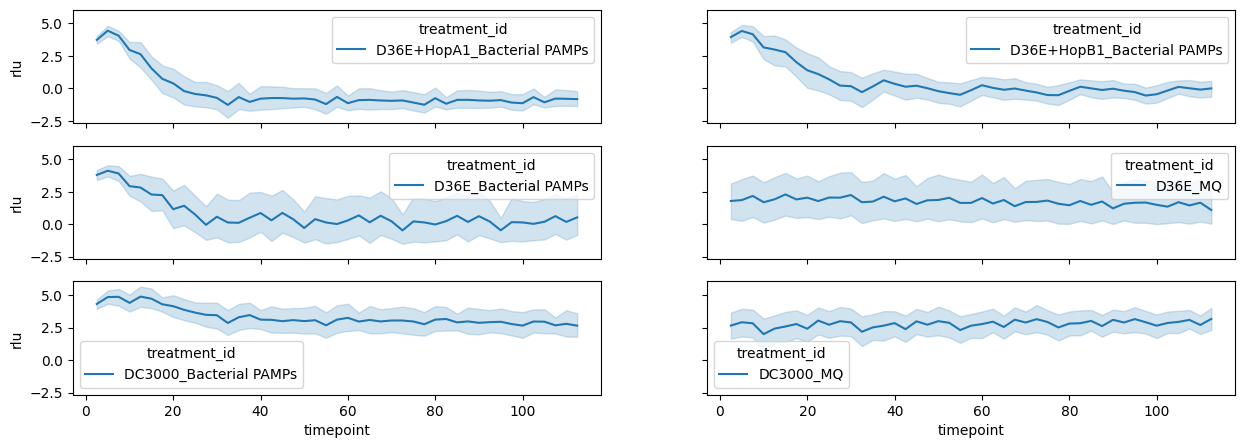

In [33]:
PLOT_VALUE = "inter_timepoint_fold_change"
PLOT_ASSAY = "plate018"

fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(15, 5))
assay_df = normalised_df[normalised_df["assay_id"] == PLOT_ASSAY]
for idx, (id, treatment_df) in enumerate(assay_df.groupby("treatment_id")):
    sns.lineplot(
        data=treatment_df,
        x="timepoint",
        y=PLOT_VALUE,
        hue="treatment_id",
        ax=axes[math.floor(idx / 2), idx % 2]
    )

The next step is to calculate the area under the curve for each treatment and each assay with a given timepoint parameter. 

In [34]:
TIMEPOINT = 50

def auc_calc(group):
    group.sort_values("timepoint", inplace=True)
    auc = np.trapz(group["inter_timepoint_fold_change"], dx=2.5)
    return auc


auc_df = normalised_df[normalised_df["timepoint"] <= TIMEPOINT]
auc_df = auc_df.groupby(["treatment_id", "assay_id", "sample_id"], as_index=False, group_keys=False).apply(auc_calc)
auc_df.rename({None: "area_under_curve"}, inplace=True, axis="columns")
auc_df


,treatment_id,assay_id,sample_id,area_under_curve
0,D36E+AvrE1_Bacterial PAMPs,plate023,plate023_A_3,-0.033396
1,D36E+AvrE1_Bacterial PAMPs,plate023,plate023_A_9,7.116140
2,D36E+AvrE1_Bacterial PAMPs,plate023,plate023_B_3,-2.348775
3,D36E+AvrE1_Bacterial PAMPs,plate023,plate023_B_9,-0.843512
4,D36E+AvrE1_Bacterial PAMPs,plate023,plate023_C_3,-1.477306
...,...,...,...,...
1626,dCEL_Bacterial PAMPs,plate033,plate033_F_9,-1.424462
1627,dCEL_Bacterial PAMPs,plate033,plate033_G_3,1.155540
1628,dCEL_Bacterial PAMPs,plate033,plate033_G_9,-0.696948
1629,dCEL_Bacterial PAMPs,plate033,plate033_H_3,-0.260006


Finally the area under curve values are plotted in a boxplot. 

<AxesSubplot: xlabel='treatment_id', ylabel='area_under_curve'>

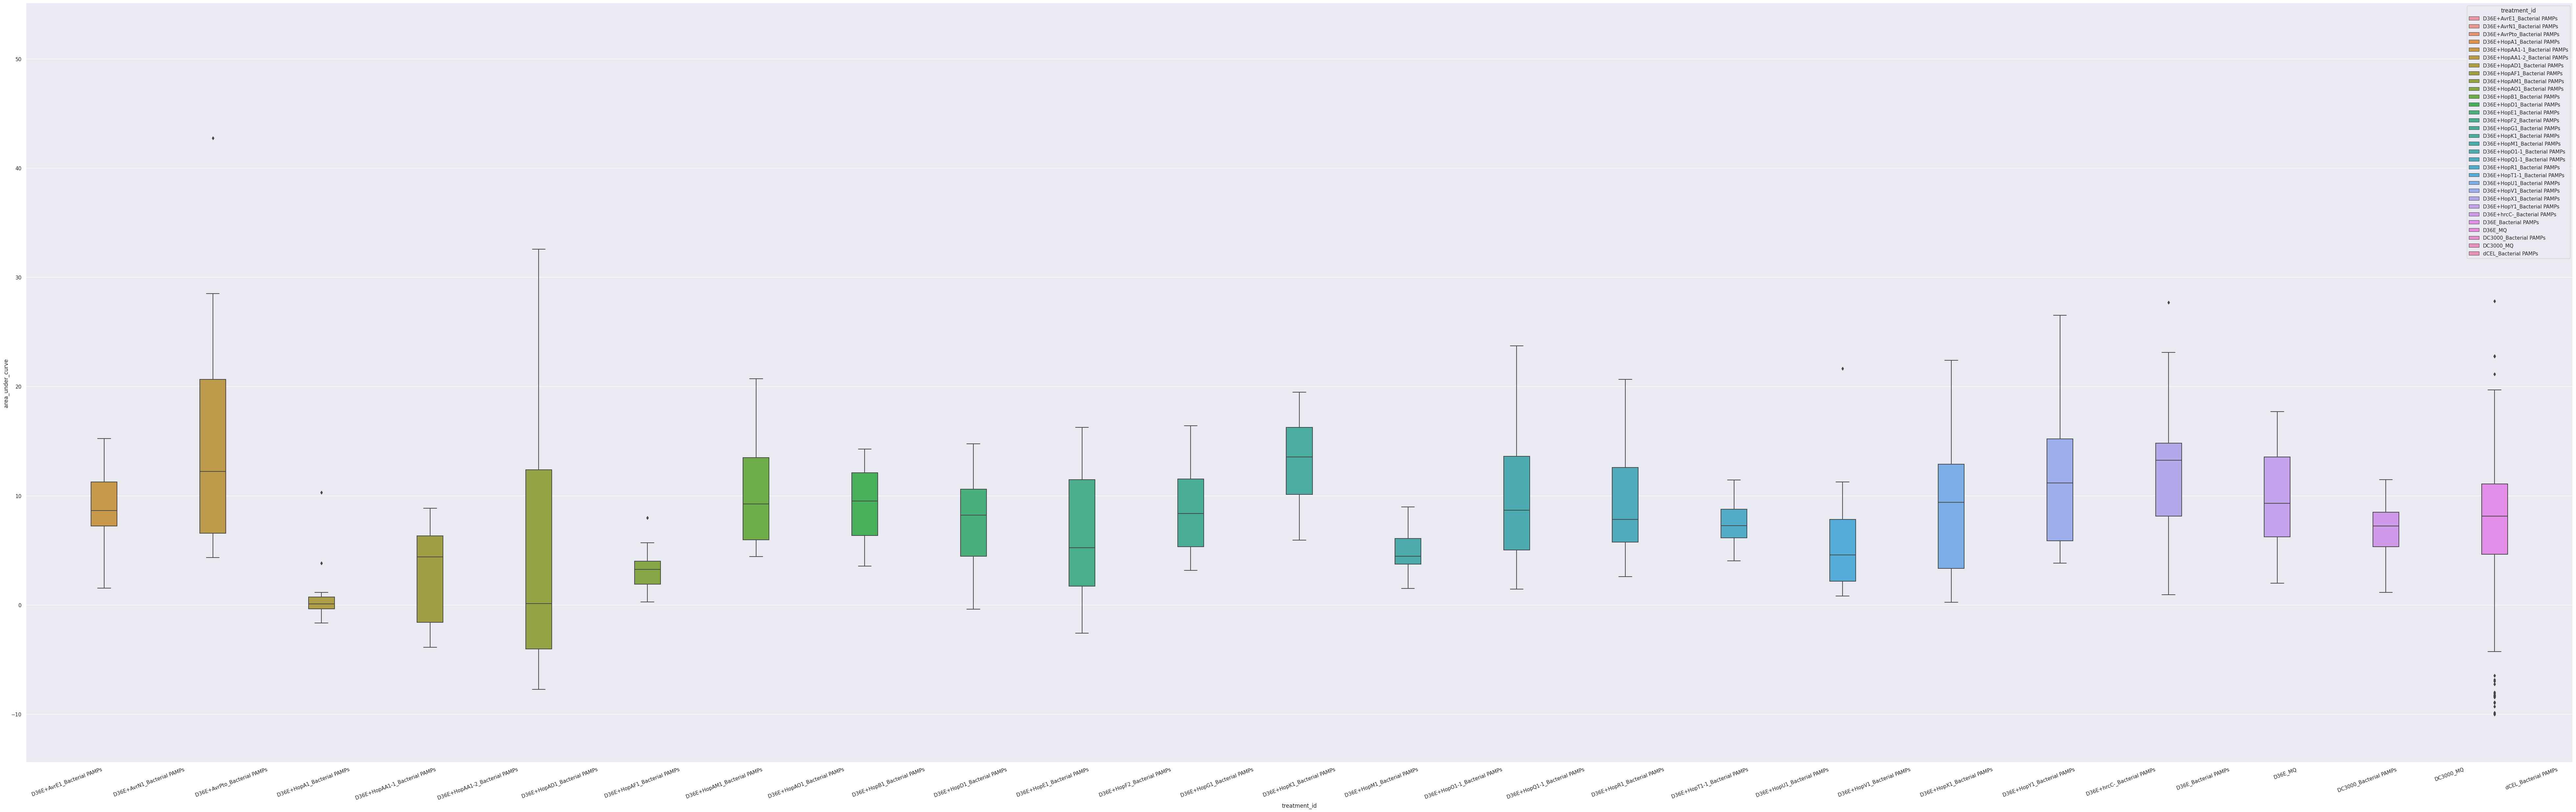

In [39]:


sns.set(rc={"figure.figsize":(100, 30)})

boxplot = sns.boxplot(
    data=auc_df,
    x="treatment_id",
    y="area_under_curve",
    hue="treatment_id",
    width=10,
)
boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=20)
boxplot